In [1]:
import random

In [2]:
import numpy as np

In [3]:
from module import *

In [4]:
from matplotlib import pyplot as plt

In [5]:
data = np.loadtxt('Admission_Predict.csv',delimiter=",", skiprows=1)[:,1:]

Se normalizarán los datos para tener una escala más uniforme y un mejor modelo. 

In [6]:
#normalización de data 
norm_t_set = np.array([np.zeros(len(data))])
for arr in data.T:
    norm_tuple = []
    for index in range(len(arr)):
        norm_tuple.append((arr[index] - arr.min())/ (arr.max()- arr.min()))
    norm_t_set = np.vstack((norm_t_set, np.array(norm_tuple)))
data = norm_t_set[1:,]
data = data.T

Separación de data en sets de training, cross validation y testing. La separación se realizará mediante índices aleatorios sin repetir, y la data será repartida de 60% (240 datos) para el training set, 20% (80 datos) para el cross validation set y 20% (80 datos) para el test set.

In [7]:
# Seleccionar conjunto de training y test

t_set = np.zeros(8).reshape((1,8))
cv_set = np.zeros(8).reshape((1,8))
test = np.zeros(8).reshape((1,8))
func = [t_set, cv_set, test]
perc = [240, 80, 80]
t_rand = []
for x in range(3):
    while(len(func[x]) < perc[x]+1):
        r = random.randint(0,399)
        if r not in t_rand: 
            t_rand.append(r)
            func[x] = np.concatenate((func[x], data[r].reshape((1,8))))
            
t_set, cv_set, test = func[0][1:,], func[1][1:,], func[2][1:,]

## Establecimiento de modelo 

Para el modelo, se tomarán todos los features del dataset, exceptuando el Serial No. (ya que no tiene correlación alguna con la variable de Chance of Admit ni provee información útil.

In [8]:
y = t_set[:,len(t_set[0])-1:len(t_set[0])]

X = np.vstack((
    np.ones(len(t_set)),
    t_set[:,:7].T,
)).T

In [9]:
m, n = X.shape

Generación de de vector theta inicial; después de múltiples generaciones aleatorias del vector theta_0, el vector que daba los mejores resultados es el siguiente:

In [10]:
theta_0 = np.array([[-0.06706054],
 [ 0.21327747],
 [-0.19349977],
 [ 0.10454866],
 [-0.06015129],
 [ 0.28915204],
 [ 0.27315269],
 [-0.00179598]])

In [12]:
#Cálculo de descenso al gradiente
theta = gradient_descent(
    X,
    y,
    theta_0,
    linear_cost_regular,
    linear_cost_derivate_regular,
    alpha=0.001,
    threshold=0.001,
    max_iter= 300000,
    lamda=0
)

In [13]:
y_predic = np.matmul(X, theta)

In [14]:
#Cálculo de coeficiente de determinación (R^2) para saber qué tan bueno fue el fit del modelo. 

r2_t = (((y-y.mean())**2).sum()-((np.matmul(X, theta)-y)**2).sum())/((y-y.mean())**2).sum()
r2_t

0.8073937589533833

In [15]:
#Cálculo de Error Cuadrático Medio para saber qué tanto se equivocó el modelo 
ecm_t = (1/len(t_set))*((y_predic-y)**2).sum()
ecm_t

0.011113734056933661

En la siguiente gráfica se ejemplifica qué tan parecido fue la predicción del modelo, al valor real de Chance of Admit. Se establecerá un feature cualquiera en el eje X (se tomó la feature de GRE Score,, porque lo que interesa es ver cómo se plotean los puntos en el eje Y.

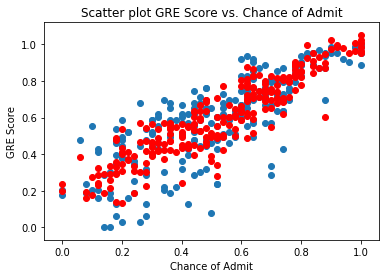

In [173]:
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 1], y_predic, color='red')
plt.title('Scatter plot GRE Score vs. Chance of Admit')
plt.xlabel('Chance of Admit')
plt.ylabel('GRE Score')
plt.show()

## Cross-Validation
Después de obtener el theta que mejor resultados brinda, se realizan las pruebas con el cross-validation set para tunear de mejor manera el modelo. 

In [100]:
#Generación de modelo para los datos del set de cross validation
cv_x = np.vstack((
    np.ones(len(cv_set)),
    cv_set[:,:7].T
)).T


cv_y = cv_set[:,len(cv_set[0])-1:len(cv_set[0])]

In [101]:
#descenso al gradiente para datos del CV set. 
theta = gradient_descent(
    cv_x,
    cv_y,
    theta_0,
    linear_cost_regular,
    linear_cost_derivate_regular,
    alpha=0.001,
    threshold=0.001,
    max_iter= 300000,
    lamda=0
)

In [102]:
#Cálculo de coeficiente de determinación (R^2)
r2_cv = (((cv_y-cv_y.mean())**2).sum()-((np.matmul(cv_x, theta)-cv_y)**2).sum())/((cv_y-cv_y.mean())**2).sum()
r2_cv

0.7698726856780918

In [103]:
#Error Cuadrático Medio
ecm = (1/len(cv_set))*((np.matmul(cv_x, theta)-cv_y)**2).sum()
ecm

0.009107249326991166

Similar a lo realizado para el set de datos para training, se graficará la predicción vs el valor real estableciendo en el eje X un feature cualquiera del modelo. 

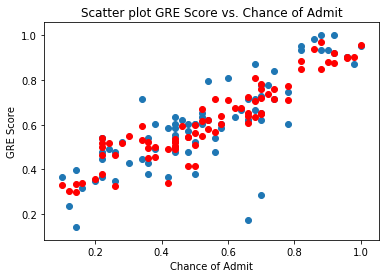

In [172]:
plt.scatter(cv_x[:, 1], cv_y)
plt.scatter(cv_x[:, 1], np.matmul(cv_x, theta), color='red')
plt.title('Scatter plot GRE Score vs. Chance of Admit')
plt.xlabel('Chance of Admit')
plt.ylabel('GRE Score')
plt.show()

## Regularización del modelo 

Con los resultados de R^2 y el Error Cuadrático Medio obtenidos previamente se puede observar que el modelo funciona bastante bien con el set de datos de cross validation. Aún así, se presentarán las gráficas de costo vs. complejidad del modelo y costo vs. lambda para observar si es posible encontrar un mejor modelo. Se definirá como complejidad a la cantidad de features incluídas en el modelo, hasta ahora se ha trabajado con una complejidad de 7. 

In [27]:
#ECM para datos de training
t_ecm = np.array([])
t_lamdas = np.linspace(-15, 30, 15)

#iteración para obtener ECM con distintos valores de lambda
for l in t_lamdas:
    theta = gradient_descent(
        X,
        y,
        theta_0,
        linear_cost_regular,
        linear_cost_derivate_regular,
        alpha=0.001,
        threshold=0.001,
        max_iter=30000,
        lamda=l)
    ecm = (1/len(t_set))*((np.matmul(X, theta)-y)**2).sum()
    t_ecm = np.append(t_ecm, ecm)

In [28]:
#ECM para datos de cross validation
cv_ecm = np.array([])
cv_lamdas = np.linspace(-15, 30, 15)

for l in cv_lamdas:
    theta = gradient_descent(
        cv_x,
        cv_y,
        theta_0,
        linear_cost_regular,
        linear_cost_derivate_regular,
        alpha=0.001,
        threshold=0.001,
        max_iter=30000,
        lamda=l)
    ecm = (1/len(cv_set))*((np.matmul(cv_x, theta)-cv_y)**2).sum()
    cv_ecm = np.append(cv_ecm, ecm)

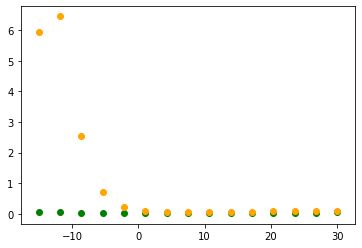

In [29]:
plt.scatter(t_lamdas, t_ecm, color='green')
plt.scatter(cv_lamdas, cv_ecm, color='orange')
plt.show()

#### Se volverán a realizar las gráficas anteriores para poder observar de mejor manera cuál es el lambda más óptimo: 

In [43]:
#ECM para datos de training
t_ecm = np.array([])
t_lamdas = np.linspace(0, 15, 10)

for l in t_lamdas:
    theta = gradient_descent(
        X,
        y,
        theta_0,
        linear_cost_regular,
        linear_cost_derivate_regular,
        alpha=0.001,
        threshold=0.001,
        max_iter=30000,
        lamda=l)
    ecm = (1/len(t_set))*((np.matmul(X, theta)-y)**2).sum()
    t_ecm = np.append(t_ecm, ecm)

In [44]:
#ECM para datos de cross validation
cv_ecm = np.array([])
cv_lamdas = np.linspace(0, 15, 10)

for l in cv_lamdas:
    theta = gradient_descent(
        cv_x,
        cv_y,
        theta_0,
        linear_cost_regular,
        linear_cost_derivate_regular,
        alpha=0.001,
        threshold=0.001,
        max_iter=30000,
        lamda=l)
    ecm = (1/len(cv_set))*((np.matmul(cv_x, theta)-cv_y)**2).sum()
    cv_ecm = np.append(cv_ecm, ecm)

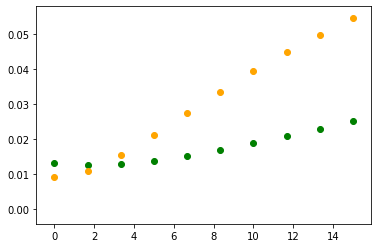

In [45]:
plt.scatter(t_lamdas, t_ecm, color='green')
plt.scatter(cv_lamdas, cv_ecm, color='orange')
plt.show()

Con la gráfica anterior se puede observar que el lambda más óptimo es de alrededor 8. Verificaremos si sí se logra mejorar la predicción. 

In [163]:
#modificacion de lambda para mejores resultados 
theta = gradient_descent(
    cv_x,
    cv_y,
    theta_0,
    linear_cost_regular,
    linear_cost_derivate_regular,
    alpha=0.001,
    threshold=0.001,
    max_iter=30000,
    lamda=0.01)

In [164]:
r2 = (((cv_y-cv_y.mean())**2).sum()-((np.matmul(cv_x, theta)-cv_y)**2).sum())/((cv_y-cv_y.mean())**2).sum()
r2

0.7710520707936307

In [165]:
#Error Cuadrático Medio
ecm = (1/len(cv_set))*((np.matmul(cv_x, theta)-cv_y)**2).sum()
ecm

0.00906057536161942

Como se puede ver, la regularización sí logró la mejora del modelo, aunque no haya sido por mucho. El lambda escogido fue pequeño ya que, como se ve en la gráfica anterior, conforme va creciendo también crece el error del modelo, por lo que un lambda muy pequeño da mejores resultados que sin la regularización, a pesar que éste sea cercano a 0. 

## Testing

A continuación, luego de haber obtenido un descenso al gradiente relativamente satisfactorio con el modelo establecido, se procederá a usar el mismo con el set de testing, y ver los resultados. 

In [167]:
x_test = np.vstack((
    np.ones(len(test)),
    test[:,:7].T
)).T


y_test = test[:,len(test[0])-1:len(test[0])]

In [168]:
#Cálculo de coeficiente de determinación (R^2)
r2_test = (((y_test-y_test.mean())**2).sum()-((np.matmul(x_test, theta)-y_test)**2).sum())/((y_test-y_test.mean())**2).sum()
r2_test

0.8108761286939817

In [169]:
#Error Cuadrático Medio
ecm = (1/len(test))*((np.matmul(x_test, theta)-y_test)**2).sum()
ecm

0.007925123789411176

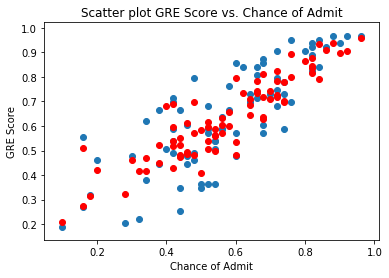

In [171]:
plt.scatter(x_test[:, 1], y_test)
plt.scatter(x_test[:, 1], np.matmul(x_test, theta), color='red')
plt.title('Scatter plot GRE Score vs. Chance of Admit')
plt.xlabel('Chance of Admit')
plt.ylabel('GRE Score')
plt.show()

## Conclusión

Con los resultados anteriores se observa que el modelo logró una predicción relativamente buena para los datos del set de testing. Se fundamenta el desempeño del modelo al observar el coeficiente de determinación (R^2) - el cual determina qué tan buen ajuste proveyó al modelo con la tendencia de los datos - calculado es bastante alto (0.81 para el set de test) e incluso el Error Cuadrático Medio - el cual estima la diferencia entre el estimador y lo que se estima - es bastante cercano a 0, lo que quiere decir que el promedio de error fue muy bajo. 

Adicionalmente, en el último scatter plot se visualiza gráficamente que las predicciones realizadas se ajustaron bastante bien a la nube de puntos de los valores reales. 